In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import PIL
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import random
import librosa

2022-03-31 14:43:11.482949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 14:43:11.482983: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATASET_PATH = "/home/gmallet/datasets/gtzan"
ROI_PATH = DATASET_PATH + "/genres_original/"
TIME_SERIES_LENGTH = 128
HOP_LENGTH = 512
CATEGORIES = os.listdir(ROI_PATH)

sr = 22050
SONG_DURATION = 29
TOTAL_SAMPLES = SONG_DURATION * sr
NB_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NB_SLICES)

def get_files(root_path, extension):
    files_paths = []
    for root, _, files in os.walk(root_path, topdown=True):
        files_paths += [os.path.join(root, file) for file in files if file.endswith(extension)]
    return files_paths


def extract_audio_features(files_paths):
    labels = []
    features = []
    for i, file_path in enumerate(files_paths):
        song, sr = librosa.load(file_path, duration=SONG_DURATION)
        genre = file_path.split("/")[-2]
        index = CATEGORIES.index(genre)
        for s in range(NB_SLICES):
            start_sample = SAMPLES_PER_SLICE * s
            end_sample = start_sample + SAMPLES_PER_SLICE
            mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
            mfcc = mfcc.T
            labels.append(index)
            features.append(mfcc.tolist())
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, len(files_paths)), end=''
        )
    print()
    return (np.array(features), np.array(labels))

def load_data(files_path):
    files_paths = get_files(files_path, "wav")
    random.shuffle(files_paths)
    a, b = int(len(files_paths) * 0.8), int(len(files_paths) * 0.9)
    train_fp, val_fp, test_fp = files_paths[:a], files_paths[a:b], files_paths[b:]

    # SHOULD SAVE THIS TO JSON OR SMTHG
    return {
        "train": extract_audio_features(train_fp),
        "validate": extract_audio_features(val_fp),
        "test": extract_audio_features(test_fp),
    }

dataset = load_data(ROI_PATH)

Extracted features audio track 799 of 799.
Extracted features audio track 100 of 100.
Extracted features audio track 100 of 100.


In [3]:
def get_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

(125, 13, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 62, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                         

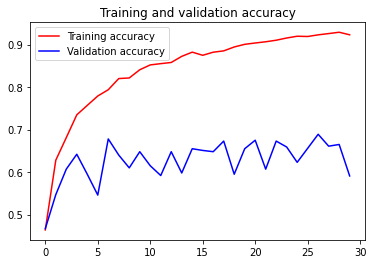

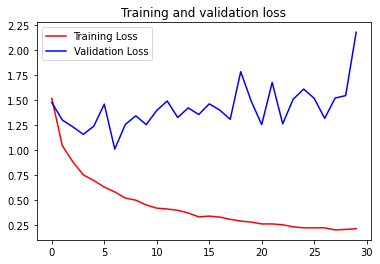

In [5]:
input_shape = (dataset["train"][0].shape[1], dataset["train"][0].shape[2], 1)
print(input_shape)
model = get_model(input_shape)
model.compile(optimizer = "adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()
history = model.fit(dataset["train"][0], dataset["train"][1],
                    validation_data=dataset["validate"],
                    epochs=30,
                    batch_size=40
                    )


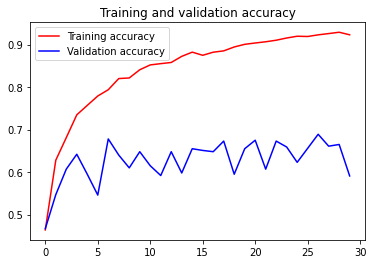

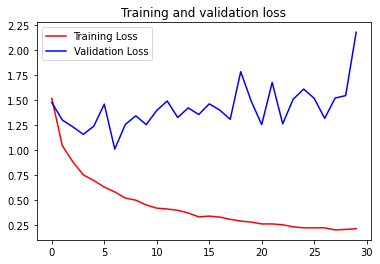

In [6]:
# EXPECTED BETTER, RAN THIS MULTIPLE TIME, SAME RESULT EVERY TIME
plot_performance(history)

In [7]:
# EVALUATION
model.evaluate(
    dataset["test"][0], dataset["test"][1], batch_size=20, verbose=1
)
# MODEL IS PRETTY ACCURATE THO!

50/50 [==============================] - 1s 7ms/step - loss: 1.4410 - acc: 0.7290


[1.441014289855957, 0.7289999723434448]